In [1]:
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import numpy as np
import csv
import pandas as pd
import time
import json
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import statsmodels.formula.api as smf
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes, mark_inset
sns.set_style("whitegrid")
sns.set_context("poster")
from collections import Counter

In [2]:
try:
    import cPickle as pickle
except:
    import pickle

In [ ]:
temp_data = {}
for year in range(1999, 2016):
    url = "https://en.wikipedia.org/wiki/"+str(year)+"%E2%80%93"+str(year+1)[-2:]+"_UEFA_Champions_League"
    soup = BeautifulSoup(requests.get(url).text, "html.parser")
    temp_data[int(year)] = soup
    
with open('cl_raw.pickle', 'wb') as handle:
    pickle.dump(temp_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
with open('cl_raw.pickle', 'rb') as handle:
    temp_data = pickle.load(handle)

In [ ]:
# Update Data
%run scrape_tables.py

In [4]:
def scrapeChampionLeagueTable(table):
    return [unicode(row.find('td').a['title']) for row in table.find_all("tr")[1:]]

def cleanVals(lst):
    return [" ".join([t_ for t_ in t.split(" ") if len("".join(t_.split('.')))>=4]) for c, t, i in vals]   

def scrapeKnockout(lst):
    vals = []
    for flag in lst:
        try:
            flag.parent.b.text
        except AttributeError:
            vals.append((flag.a['title'], flag.findNext('a').findNext('a')['title'], 0))
        else:
            vals.append((flag.a['title'], flag.findNext('a').findNext('a')['title'], 1))
    return vals

In [ ]:
championLeagueDict = {}
for k,v in temp_data.iteritems():
    round_ = 0
    try:
        val = v.find('span', id=['First_group_stage', 'Group_stage']).parent
        print k
    except AttributeError:
        championLeagueDict[k] = {r : [] for r in range(1,7)}
        print k
    else:
        while val:
            split = val.findNext('h3').span.text.split(' ')
            if split[0] == 'Group':
                if split[1] == 'A':
                    round_ += 1
                val = val.findNext('h3')
                try:
                    t = scrapeChampionLeagueTable(val.findNext('table').table)
                except:
                    t = scrapeChampionLeagueTable(val.findNext('table'))
                try:
                    championLeagueDict[k][round_] = championLeagueDict[k][round_] + t
                except KeyError:
                    championLeagueDict[k] = {r : [] for r in range(1,7)}
                    championLeagueDict[k][round_] = t
            else:
                val = False
    vals = scrapeKnockout(v.find('span', id=['Knockout_stage', 'Knockout_phase', 'Bracket']).findNext('table').find_all('span', class_='flagicon'))
    cleaned_vals = []
    for a, (b1, b2, b3) in zip(cleanVals(vals), vals):
        cleaned_vals.append((b1, a, b3))
    championLeagueDict[k][6] = [Counter(cleaned_vals).most_common()[0][0][0]]
    vals = []
    for b1,b2,b3 in cleaned_vals:
        vals.append((b1,b2))
    rev_dict = {}
    for k_, v_ in Counter(vals).most_common():
        try:
            rev_dict[v_].append(k_)
        except KeyError:
            rev_dict[v_] = [k_]
    for k_, v_ in rev_dict.iteritems():
        round__ = round_
        counter = k_
        while counter:
            round__ += 1
            championLeagueDict[k][round__] = championLeagueDict[k][round__]+[c for c, t in v_]
            counter -= 1

In [ ]:
dictionary_something = {}
for k, v in championLeagueDict.iteritems():
    countries = list(set(v[1]))
    dictionary_something[k] = {c : [] for c in countries}
    for c in countries:
        for _, v_ in v.iteritems():
            val = Counter(v_)[c]
            dictionary_something[k][c].append(val)
print dictionary_something[1999]

In [5]:
def positionate(n, df_):
    df = df_.copy()
    res = df.apply(lambda row: [[row['Year'],data] for data in row['Raw_Data']], axis=1)
    rawdata = pd.DataFrame([i for sublist in res for i in sublist])
    rawdata.columns = ["Year", "Points"]
    t = map(list, zip(*df.Raw_Data)) 
    tt = map(list, zip(*t))
    test = df.apply(lambda row: [[20*(i+1)/float(n), data] for i, data in enumerate(row['Raw_Data'])], axis=1)
    test_ = pd.DataFrame([i for sublist in test for i in sublist])
    test_.columns = ["Rank", "Points"]
    return test_, 19*(pd.DataFrame(t).index)/float(n-1)+1, pd.DataFrame(tt).std(), pd.DataFrame(tt).mean()

def dict_to_parsed_df(d):
    data = []
    for k, v in d.iteritems():
        if v is not None:
            try:
                temp = dict_to_df(v)
                temp.Pts = temp.Pts.astype(int)
                data.append([k, gini_coeff(temp.Pts), temp.Pts.mean(), temp.Pts.std(), temp.Pts, ])
            except AttributeError:
                temp = dict_to_df(v)
                temp.Pts = temp.Points.astype(int)
                temp.drop('Points', axis=1, inplace=True)
                data.append([k, gini_coeff(temp.Pts), temp.Pts.mean(), temp.Pts.std(), temp.Pts, ])
            except:
                print k
    df = pd.DataFrame(data)
    df.columns = ["Year", "Gini", "Mean", "Std", "Raw_Data"]
    df.sort('Year', inplace=True)
    return df.reset_index(drop=True)

def helper(df_):
    df = df_.copy()
    try:
        df['Team']
    except KeyError:
        for i, column in enumerate(df.columns):
            if len(column.split("Team")) > 1:
                df.insert(1, "Team", df.iloc[:,i], allow_duplicates=False)
                df.drop(column, 1, inplace=True)
    return df

def dict_to_df(v):
    try:
        temp = pd.DataFrame(v[1:], columns=v[0])
    except:
        temp = pd.DataFrame(v[1:], columns=v[0][:-1])
#        temp["Pos"] = range(1,len(temp)+1)
#        cols = temp.columns.tolist()
#        cols = cols[-1:] + cols[:-1]
#        temp = temp[cols]
    return helper(temp)

def gini_coeff(x):
    n = len(x)
    s = x.sum()
    r = np.argsort(np.argsort(-x))
    return 1 - (2.0 * (r*x).sum() + s)/(n*s)



In [6]:
def calc_gini(top, n):
    rest = [2*(n-1-top)]*(n-top)
    v = (6*(n-top))
    scores = [l+v for l in range(0, 6*top, 6)]+rest
    return gini_coeff(np.array(scores))

In [7]:
max_gini_dict = {n : max([calc_gini(top, n) for top in range(1,n+1)]) for n in range(16,26,2)}

In [8]:
def plot_gini(ns, colors, data = False):
    for c, n in zip(colors, ns):
        ginis = {top : (calc_gini(top, n), top)  for top in range(1,n+1)}
        a,b = max(ginis.values())
        plt.plot(ginis.keys(), zip(*ginis.values())[0], color=c, label='%i teams, Max of %.03f achieved with %i teams' % (n, a, b))
        plt.scatter(ginis.keys(), zip(*ginis.values())[0], color=c, s=60)
        plt.ylabel("Gini Score")
        plt.xlabel("Number of Dominant Teams");
    plt.legend(loc='lower right', prop={'size':20})
    plt.xlim(0,max(ns)+1)
    plt.ylim(0,.4)

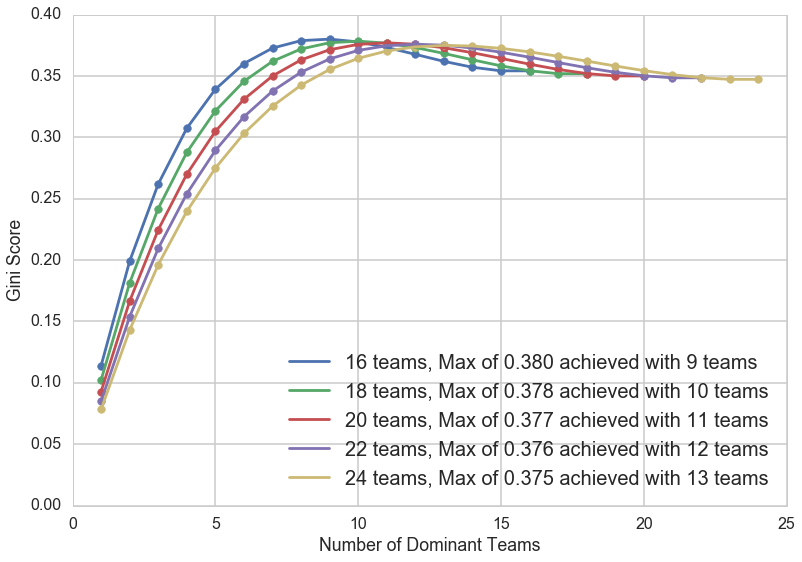

In [9]:
plot_gini(range(16,26,2), sns.color_palette(), data=True)

In [10]:
leagues = ["England", "Germany", "Portugal", "France", "Italy", "Spain"]

In [11]:
d = {}
d_parsed = {}
for l in leagues:
    with open(l+'_PL_tables.json', 'r') as fp:
        d[l] = json.load(fp)
        df = dict_to_parsed_df(d[l])
        df.Year = df.Year.astype(int)
        d_parsed[l] = df

c:\Anaconda\lib\site-packages\ipykernel\__main__.py:30: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [12]:
d_df = {k : {int(k_) : dict_to_df(v_) for k_, v_ in v.iteritems() if v_ is not None} for k, v in d.iteritems()}
points_per_win_dict_mask = {k : [sum(r)>len(r)*(len(r)-1)*2 for r in v.Raw_Data] for k, v in d_parsed.iteritems()}
league_size_dict = {k : {y : len(r) for r, y in zip(v.Raw_Data, v.Year)} for k, v in d_parsed.iteritems()}

In [13]:
def league_size_inator(d):
    # Curse you Perry the Platypus!!
    d_ = {}
    for k, v in d.iteritems():
        df = []
        for ((i, (year, gini, mean, std, raw_data)), boool) in zip(v.iterrows(), points_per_win_dict_mask[k]):
            if boool:
                l = league_size_dict[k][year]
                gini_ = gini/max_gini_dict[l]
                raw_data_ = [100*data/float((l-1)*6) for data in raw_data]
                g = (l-1)*l
                t = g*3-sum(raw_data)
                w = g-t
                mean_ = np.array(raw_data_).mean()
                std_ = np.array(raw_data_).std()
                df.append([year, gini_, mean_, std_, raw_data_])
        d_[k] = pd.DataFrame(df, columns = ['Year', 'Gini', 'Mean', 'Std', 'Raw_Data'])
    return d_

In [14]:
d_ = league_size_inator(d_parsed)

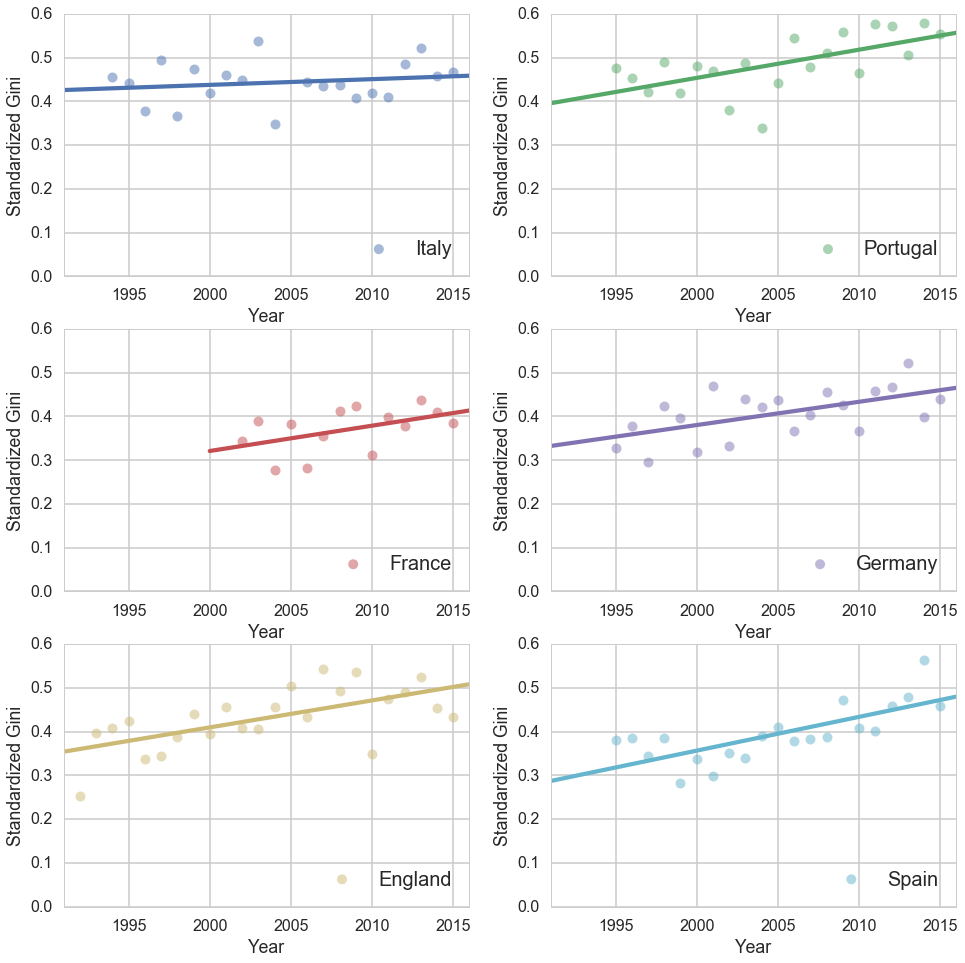

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))

for ax, (k, v)  in zip(axes.ravel(), d_.iteritems()):
    sns.regplot(x = 'Year', y = 'Gini', data = v, scatter_kws={'s':100, 'alpha' : .5}, label = k, ci = None, ax=ax)
    ax.legend(loc='lower right', prop={'size':20})
    ax.set_xlim(1991,2016)
    ax.set_ylabel("Standardized Gini")
    ax.set_ylim(0,.6);
    
plt.savefig("Gini.png")

c:\Anaconda\lib\site-packages\matplotlib\figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


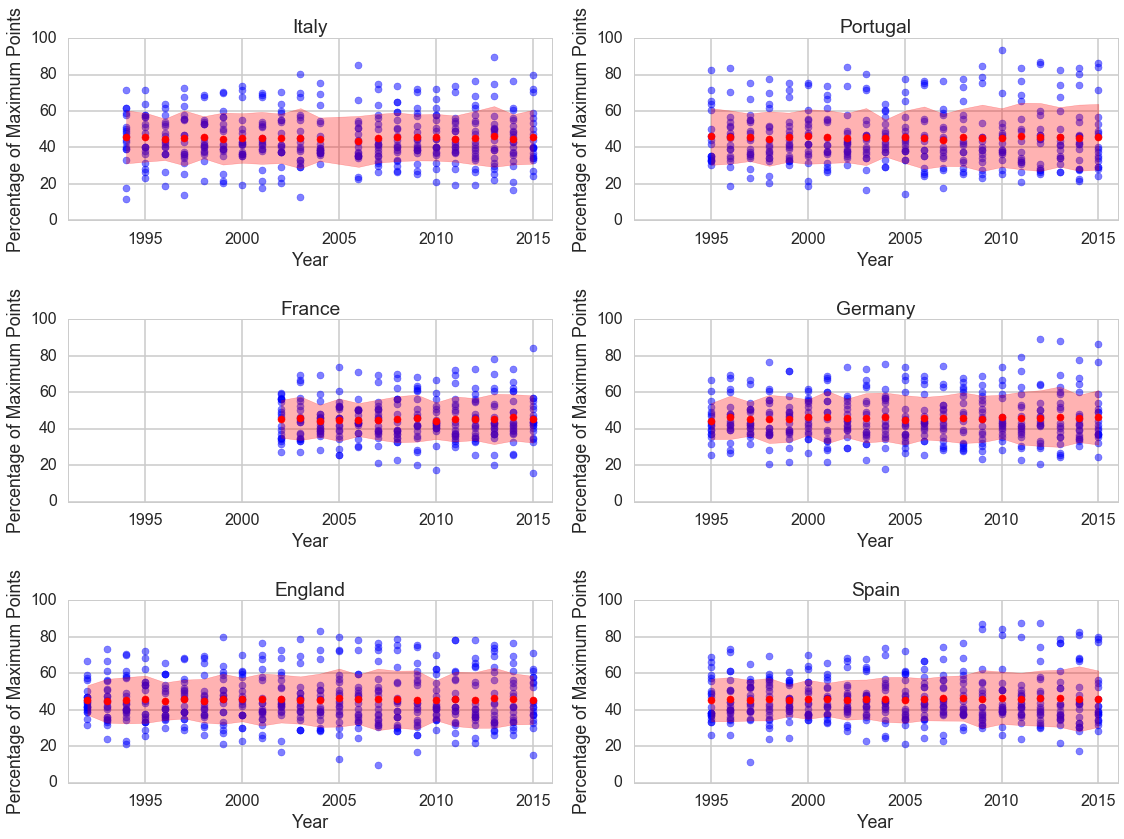

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12), tight_layout = True)

for ax, (k, v)  in zip(axes.ravel(), d_.iteritems()):
    res = v.apply(lambda row: [[row['Year'],data] for data in row['Raw_Data']], axis=1)
    rawdata = pd.DataFrame([i for sublist in res for i in sublist])
    rawdata.columns = ["Year", "Points"]
   
    x = v.Year
    y = v.Mean
    std = v.Std

    ax.scatter(x = rawdata['Year'], y = rawdata['Points'], color='b', alpha=.5, s=50)
    ax.scatter(x = x, y = y,color='r', s = 50)
    ax.fill_between(x, y-std, y+std, color='r', alpha=.3)
    ax.set_ylim(0,100)
    ax.set_xlim(1991,2016)
    ax.set_ylabel('Percentage of Maximum Points')
    ax.set_xlabel('Year')
    ax.set_title(k);

In [17]:
for k, v in d_.iteritems():
    lm = smf.ols(formula='Gini ~ Year', data=v).fit()
    print k, lm.summary(), '\n\n\n'
    #print k, lm.pvalues, lm.params, '\n\n\n'
    

Italy                             OLS Regression Results                            
Dep. Variable:                   Gini   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.6654
Date:                Fri, 12 Aug 2016   Prob (F-statistic):              0.425
Time:                        05:13:33   Log-Likelihood:                 35.130
No. Observations:                  21   AIC:                            -66.26
Df Residuals:                      19   BIC:                            -64.17
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -2.1808      3.217     -0.678   

c:\Anaconda\lib\site-packages\scipy\stats\stats.py:1557: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


In [18]:
def get_index_inator(d_, n):
    # Mom Phineas and Ferb are making a title sequence
    d_len = {}
    for k, v in d_.iteritems():
        v['n'] = v.apply(lambda row : len(row.Raw_Data), axis = 1)
        for g, g_ in itertools.groupby(reversed(v['n'])):
            if len(list(g_))>=n:
                d_len[k] = g
                break
        vals = v[v.n == d_len[k]].index.tolist()[-n:]
        d_len[k] = (d_len[k], v[vals[0]:vals[0]+n])
    return d_len

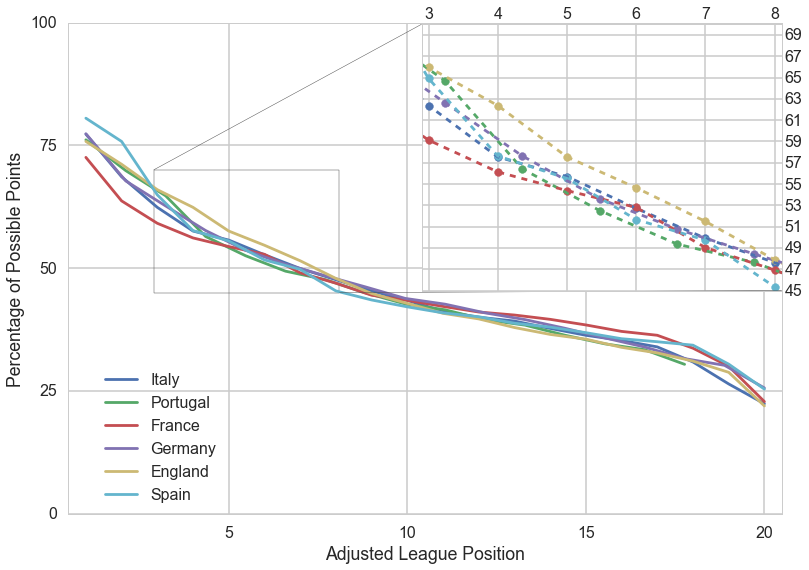

In [19]:
fig, ax = plt.subplots()
n = 10
colors = sns.color_palette()
#plt.figure(figsize=(10, 10))
for c, (k, v) in zip(colors, get_index_inator(d_, n).iteritems()):
    test_, pos, std, mean, = positionate(*v)
    #print k, mean
    plt.plot(pos, mean, color=c, linestyle='-', label = k)
    #plt.fill_between(pos, mean-std, mean+std, color=c, alpha=.3)
    plt.xlim([0.5,20.5])
    plt.ylim([0,100]);
    plt.xlabel('Adjusted League Position')
    plt.ylabel('Percentage of Possible Points')
    plt.yticks(range(0,101,25))
plt.legend(frameon=False, loc = 3, bbox_to_anchor=(0.15, 0.12), bbox_transform=ax.figure.transFigure);


axins2 = inset_axes(ax, 5, 3.7, loc=2, bbox_to_anchor=(0.5, 0.91), bbox_transform=ax.figure.transFigure) # no zoom
for c, (k, v) in zip(colors, get_index_inator(d_, n).iteritems()):
    test_, pos, std, mean, = positionate(*v)
    plt.plot(pos, mean, color=c, label = k, linestyle = 'dashed')
    plt.scatter(pos, mean, color=c, label = k, s = 60)
    plt.xlim([0.5,20.5])
    plt.xticks(range(3,9))
    plt.yticks(range(45,75,2))
    axins2.xaxis.tick_top()
    axins2.yaxis.tick_right()
    axins2.tick_params(direction='in', pad=3)
    plt.ylim([0,100]);
axins2.set_xlim(2.9, 8.1) # apply the x-limits
axins2.set_ylim(45,70)
mark_inset(ax, axins2, loc1=2, loc2=4, fc="None", ec=".3");

plt.savefig("Table_Position.png")


In [23]:
#clhist = {}
#for k, v in dictionary_something.iteritems():
#    df = pd.DataFrame.from_dict(v).transpose()
#    df.columns = ['Round_of_'+str(n) for n in [32,16,8,4,2,1]]
#    clhist[k] = df
    
#with open('cl_parsed.pickle', 'wb') as handle:
#    pickle.dump(clhist, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
with open('cl_parsed.pickle', 'rb') as handle:
    clhist = pickle.load(handle)

EOFError: 

In [25]:
temp_dict = {}
for k, v in clhist.iteritems():
    v_ = v.transpose()
    for abc in v_:
        try:
            temp_dict[abc].append((k, list(v_[abc])))
        except KeyError:
            temp_dict[abc] = [(k, list(v_[abc]))]

NameError: name 'clhist' is not defined

In [26]:
def cl_score(lst):
    c = 1
    f = 0
    for v in lst:
        if f:
            f -= c*v
            c *= 2
        f += c*v
    return f/float(32)

In [27]:
cl_score_d = {}
for k, v in d_.iteritems():
    c = 1
    while c:
        try:
            cl_score_d[k].append((temp_dict[k][c-1][0], cl_score(temp_dict[k][c-1][1])))
            c += 1
        except KeyError:
            cl_score_d[k] = [(temp_dict[k][c-1][0], cl_score(temp_dict[k][c-1][1]))]
        except IndexError:
            break
        

KeyError: 'Italy'

In [28]:
best_counties_d = {sum([cl_score(v[1]) for v in vs]) : (k, vs) for k, vs in temp_dict.iteritems() }

In [29]:
def printSpaced(*args):
    if len(args) == 1:
        args = args[0]
    maxes = [max([len(str(a)) for a in arg]) for arg in args]
    for a in zip(*args):
        for i, a_ in enumerate(a):
            while len(str(a_))<maxes[i]:
                a_ = str(a_)+" "
            print a_,
        print "\n",

In [30]:
printSpaced(zip(*[(c, best_counties_d[c][0]) for c in sorted(best_counties_d.keys(), reverse=True)]))

In [31]:
def plott(vs, c, k = None):
    for i, v in enumerate(vs):
        if i:
            plt.scatter(v[0], cl_score(v[1]), color = c, s=100)
        else:
            plt.scatter(v[0], cl_score(v[1]), color = c, s=100, label = k)

In [32]:
n = 4
c = 1
figsize=(16, 12)
ind = True
cs = sns.color_palette(n_colors=n+1)
for k, vs in temp_dict.iteritems():   
    if k in [best_counties_d[c_][0] for c_ in sorted(best_counties_d.keys(), reverse=True)[:n]]:
        plott(vs, cs[c], k)
        c += 1
    else:
        if ind:
            ind = False
            plott(vs, cs[0], 'Other Leagues')
        else:
            plott(vs, cs[0])
    plt.xlim([1999.5,2015.5])
    plt.ylim([0, 2])
    plt.legend(bbox_to_anchor=(1.3, .6), prop={'size':20})

In [33]:
cl_score_d_year = {}
for k, vs in cl_score_d.iteritems():
    for v in vs:
        try:
            cl_score_d_year[v[0]].append((k, v[1]))
        except KeyError:
            cl_score_d_year[v[0]] = [(k, v[1])]

In [34]:
cl_score_d_ = {}
for k, vs in cl_score_d_year.iteritems():
    sm = sum([v[1] for v in vs])
    sm = 3.5
    for v in vs:
        try:
            cl_score_d_[v[0]].append((k, v[1]/float(sm)))
        except KeyError:
            cl_score_d_[v[0]] = [(k, v[1]/float(sm))]

In [35]:
cl_reg = {}
for k, vs in cl_score_d_.iteritems():
    for v in vs:
        try:
            cl_reg[k].append((v[1], float(d_[k][d_[k].Year == v[0]].Gini)))
        except KeyError:
            try:
                cl_reg[k] = [(v[1], float(d_[k][d_[k].Year == v[0]].Gini))]
            except:
                pass
        except:
            pass

In [36]:
for k, v in cl_reg.iteritems():
    v_ =  pd.DataFrame(v, columns = ["Percent", "Gini"])
    lm = smf.ols(formula='Percent ~ Gini', data=v_).fit()
    print k, lm.summary(), '\n\n\n'

In [37]:
d['France']['2006'][15][1] = "Paris Saint-Germain"

In [38]:
def scrubbed(d, splits = ['\\', '!', "("]):
    tpl = d.values()
    for s in splits:
        tpl = tuple([v.split(s)[0].rstrip() for v in tpl])
    tpl = np.unique(tpl)
    for k, v in d.iteritems():
        for t in tpl:
            if t in v:
                d[k] = t
    print "Scrubbed"
    return d
        
def parsed_dict(d, rigorous = False):
    translations = d.copy()
    again = True
    while again:
        values = np.unique(translations.values())
        init_len = len(values)
        for k, v in translations.iteritems():
            for val in values:
                if val in k:
                    try:
                        translations[k] = translations[val]
                    except KeyError:
                        translations[k] = val
        fin_len = len(np.unique(translations.values()))
        if init_len == fin_len:
            print "Compressed to", fin_len
            again = False
        else:
            print "Compressing from", init_len, "to", fin_len,"..."
    if rigorous:
        return parsed_dict(scrubbed(translations))
    else:
        return translations
    
def space(s):
    return s.replace(u'\xa0', u' ')
    
def translatorinator(d, rigorous=True):
    translations = {}
    dfs = {}
    for k, v_ in d.iteritems():
        print "\n", k
        l = []
        dfs[k] = {int(k): dict_to_df(v) for k, v in v_.iteritems() if v is not None}
        for a, b in dfs[k].iteritems():
            try:
                l = l+list(b['Team'])
            except KeyError:
                l = l+list(b['Club'])
                d[k][str(a)][0][d[k][str(a)][0].index("Club")] = 'Team'
        translations_ = {space(v): space(v) for v in np.unique(l)}
        translations[k] = parsed_dict(translations_, rigorous)
    return translations, dfs

In [39]:
%%capture
_, _ = translatorinator(d)

In [40]:
translations, dfs = translatorinator(d)


Italy
Compressing from 119 to 56 ...
Compressing from 56 to 47 ...
Compressed to 47
Scrubbed
Compressed to 47

Portugal
Compressing from 111 to 60 ...
Compressing from 60 to 47 ...
Compressed to 47
Scrubbed
Compressed to 43

France
Compressing from 110 to 48 ...
Compressing from 48 to 39 ...
Compressed to 39
Scrubbed
Compressed to 38

Germany
Compressing from 112 to 57 ...
Compressing from 57 to 50 ...
Compressed to 50
Scrubbed
Compressed to 45

England
Compressing from 134 to 65 ...
Compressing from 65 to 54 ...
Compressed to 54
Scrubbed
Compressed to 47

Spain
Compressing from 126 to 72 ...
Compressing from 72 to 60 ...
Compressed to 60
Scrubbed
Compressing from 56 to 51 ...
Compressed to 51


In [41]:
def translate(c1, c2, translations):
    c1_ = [translations[space(s)] for s in c1]
    c2_ = [translations[space(t)] for t in c2]
    d = {}
    for i, a in enumerate(c1_):
        if a not in c2_:
            d[a] = (i+1, len(c2_)+1)
        else:
            for i_, b in enumerate(c2_):
                if b in c1_:
                    if a == b:
                        d[a] = (i+1,i_+1)
                else:
                    d[b] = (len(c1_)+1, i_+1)
                    
    return d

In [42]:
def regressify(d, translations = translations, years_past = 1, column = "Pos", twenty=True):
    out_d = {}
    for k, v in d.iteritems():
        text = "".join([str(k-years_past),"-",str(k)])
        try:
            df = d[k-years_past]
        except KeyError:
            pass
            #print "Data doesn't exist for", text
        else:
            out_d[text] = translate(df.Team, d[k].Team, translations)
            #if df.shape[0] == 20 or (twenty == False):
            #    out_d[text] = translate(df.Team, d[k].Team, translations)
            #else:
            #    pass
                #print "Excluding data from", text
    return out_d

In [43]:
def compile_everything(d, translations, years_past = 1, label = "", column = "Pos", twenty=True, s_ = 10, sep=False, output=True):
    data = regressify(d, translations, years_past, column, twenty)
    xs = []
    ys = []
    count_dict = {}
    for year, v in data.iteritems():
        for team, (x, y) in v.iteritems():
            xs.append(x)
            ys.append(y)
            tup = (x, y)
            try:
                count_dict[tup]
            except KeyError:
                count_dict[tup] = [1, [(team, year)]]
            else:
                count_dict[tup][0] += 1
                count_dict[tup][1].append((team,year))

    regress_df = pd.DataFrame(zip(xs,ys), columns=["X", 'y'])
    try:
        regression = smf.ols(formula = 'y ~ X', data = regress_df).fit()
    except ValueError:
        regression = None
    if output:
        plot1(count_dict, years_past, label, s_)
    return regression, count_dict    

def plot1(count_dict, years_past, label, s_):
    xs_, ys_ = zip(*count_dict.keys())
    plt.scatter(xs_, ys_, s = [r*s_ for r in zip(*count_dict.values())[0]])
    plt.xlim(0,24)
    plt.ylim(0,24)
    plt.ylabel('Table Position in Year n')
    plt.title('%s: Table Position in Year N-%d vs Table Position in Year N' % (label, years_past))
    plt.xlabel('Table Position in Year n-%d' % years_past)
    plt.show()

In [44]:
def changes(d, last, current):
    print "\nFrom", last, "to", current
    output = []
    for k, v in d.iteritems():
        try:
            c, v_ = v[(last, current)]
        except KeyError:
            pass
        else:
            output = output+[tuple([k, t, y]) for t, y in v_]
    a_long, b_long, c_long = zip(*output)
    ma = max([len(a) for a in a_long])
    mb = max([len(b) for b in b_long])
    mc = max([len(c) for c in c_long])
    output = sorted(output)
    for a,b,c in output:
        while len(a) < ma:
            a = a + " "
        while len(b) < mb:
            b = b + " "
        while len(c) < mc:
            c = c + " "
        print a,b, c
    return output

In [45]:
def helper_graphs(s=25, yp=1, output=True):
    b = {}
    a = {}
    for k, v in dfs.iteritems(): 
        a_,b_ = compile_everything(v, translations=translations[k], label = k, years_past=yp, s_ = s, output=output);
        a[k] = a_
        b[k] = b_

    cd = {}
    for k,v in b.iteritems():
        for k_, (c, t) in v.iteritems():
            try:
                c_, t_ = cd[k_]
            except KeyError:
                cd[k_] = [c, t]
            else:
                cd[k_] = [c+c_, t+t_]            
    if output:
        plot1(cd, yp, "All", s)
    return a, b


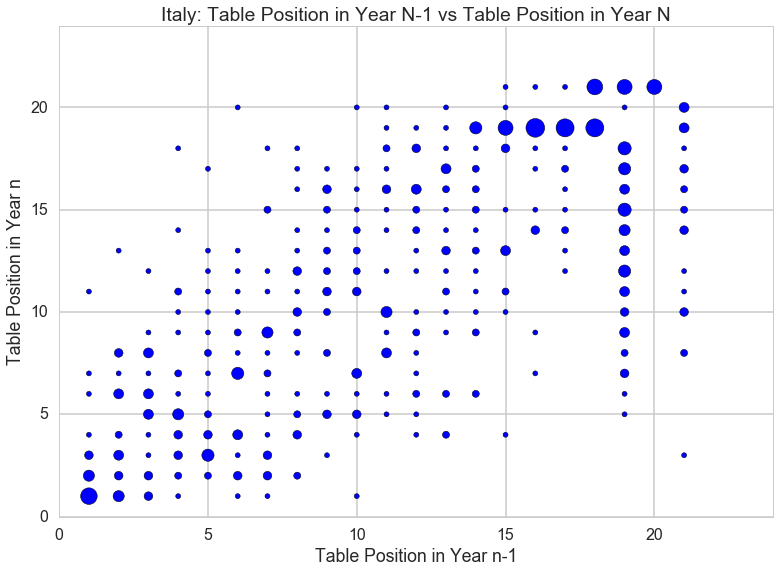

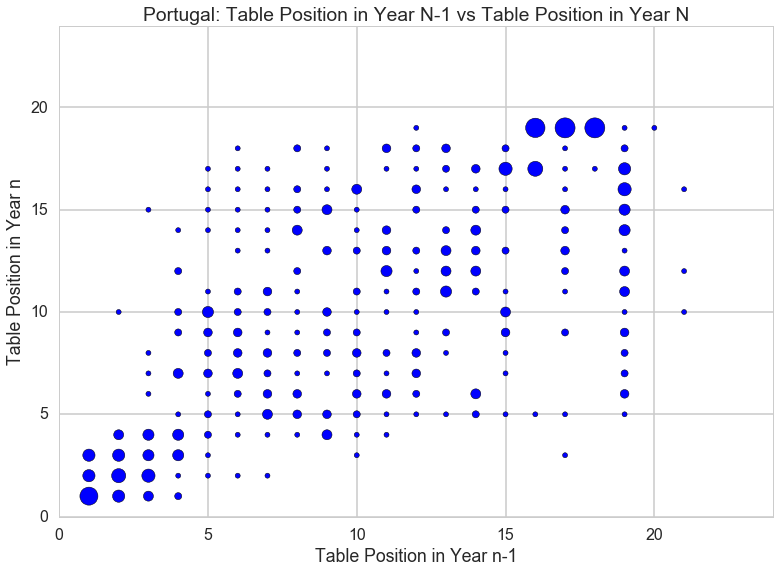

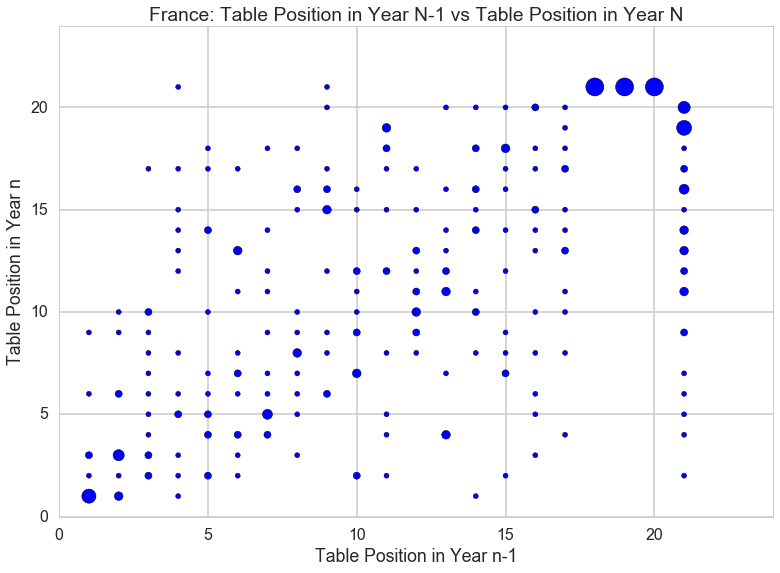

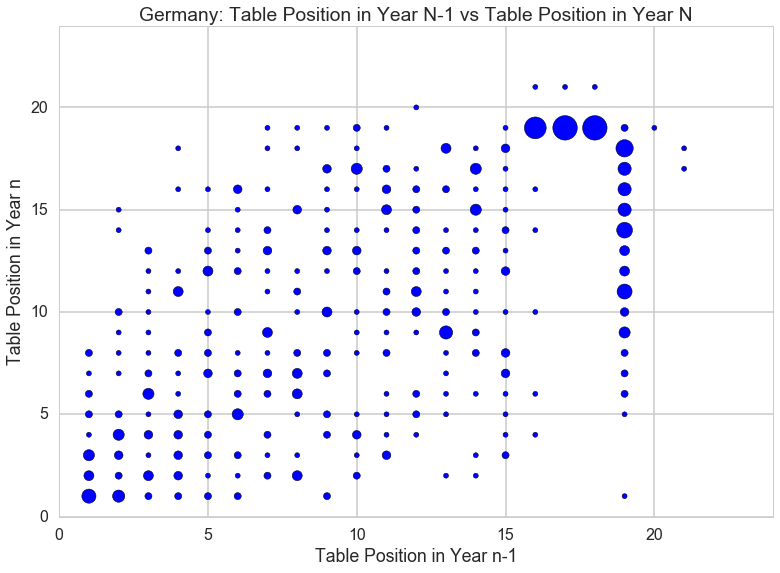

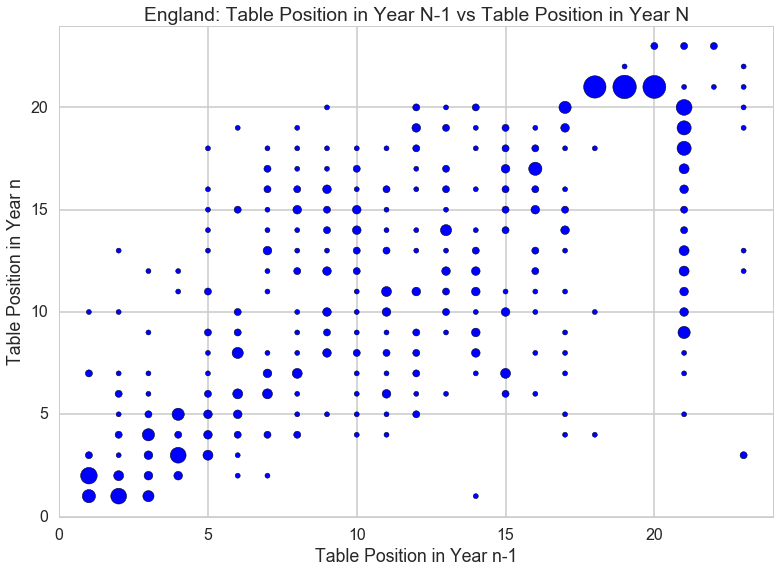

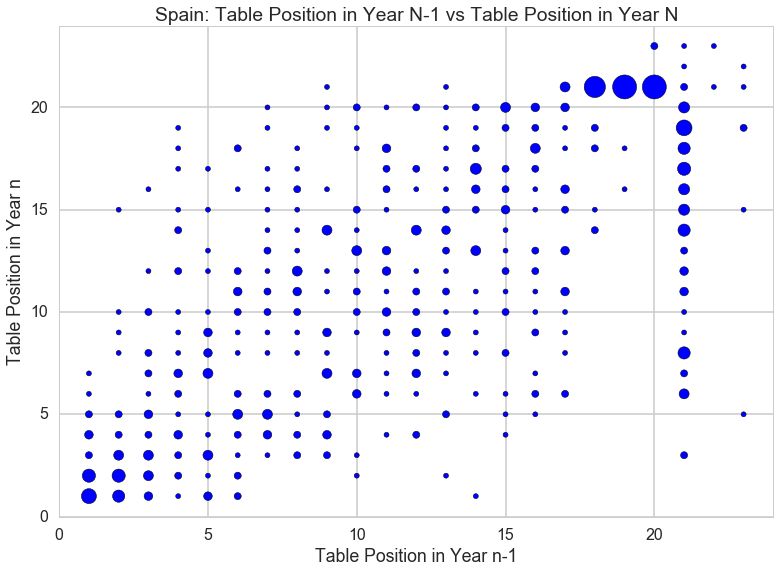

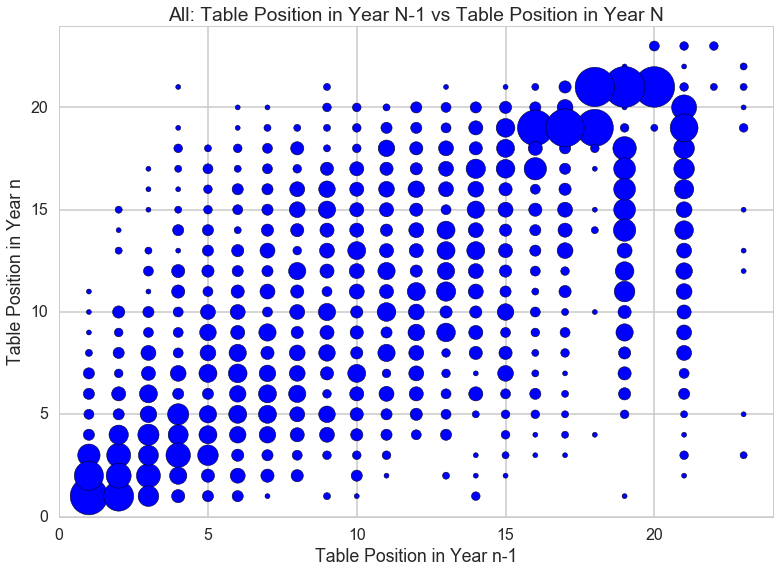

In [46]:
a, b = helper_graphs()

In [47]:
_ = changes(b, 1, 11)
_ = changes(b, 1, 10)
_ = changes(b, 1, 9)
_ = changes(b, 1, 8)
_ = changes(b, 2, 15)
_ = changes(b, 2, 14)
_ = changes(b, 2, 13)
_ = changes(b, 4, 21)


From 1 to 11
Italy Milan 1995-1996

From 1 to 10
England Chelsea 2014-2015

From 1 to 9
France Montpellier 2011-2012

From 1 to 8
Germany VfL Wolfsburg 2008-2009
Germany Werder Bremen 1992-1993

From 2 to 15
Germany Bayer Leverkusen 2001-2002
Spain   Real Sociedad    2002-2003

From 2 to 14
Germany Schalke 04 2009-2010

From 2 to 13
England Newcastle United 1996-1997
Italy   Internazionale   1992-1993

From 4 to 21
France Stade Rennais FC 2004-2005


In [48]:
_ = changes(b, 19, 1)
_ = changes(b, 14, 1)
_ = changes(b, 10, 1)
_ = changes(b, 9, 1)
_ = changes(b, 21, 2)
_ = changes(b, 15, 2)
_ = changes(b, 23, 3)
_ = changes(b, 21, 3)


From 19 to 1
Germany 1. FC Kaiserslautern 1996-1997

From 14 to 1
England Leicester City  2014-2015
France  Montpellier     2010-2011
Spain   Atlético Madrid 1994-1995

From 10 to 1
Italy Milan 1997-1998

From 9 to 1
Germany VfB Stuttgart 2005-2006
Germany Werder Bremen 1991-1992

From 21 to 2
France Monaco 2012-2013

From 15 to 2
France Bordeaux 2004-2005

From 23 to 3
England Newcastle United  1992-1993
England Nottingham Forest 1993-1994

From 21 to 3
Italy Juventus            2006-2007
Spain Betis               1993-1994
Spain Deportivo La Coruña 1991-1992


In [175]:
%%time
is_ = sorted([.95, .999, .50, .75, .99])
pval_dict = {}
pval_dict_ = {}
for y in range (1,30):
    try:
        val = helper_graphs(yp = y, output=False)[0]
    except ValueError:
        print "h", y
        break
    else:
        for k,v in val.iteritems():
            try:
                ints = []
                for i in is_:
                    ints.append([v.conf_int(1-i)[0]['X'],v.conf_int(1-i)[1]['X']])
                mid = v.params['X']
                pval_dict[k][y] = v.pvalues
                pval_dict_[k][y] = (mid, ints)
            except KeyError:
                pval_dict[k] = {y : v.pvalues}
                pval_dict_[k] = {y : (mid, ints)}
            except AttributeError:
                pass

Wall time: 2.48 s


Italy


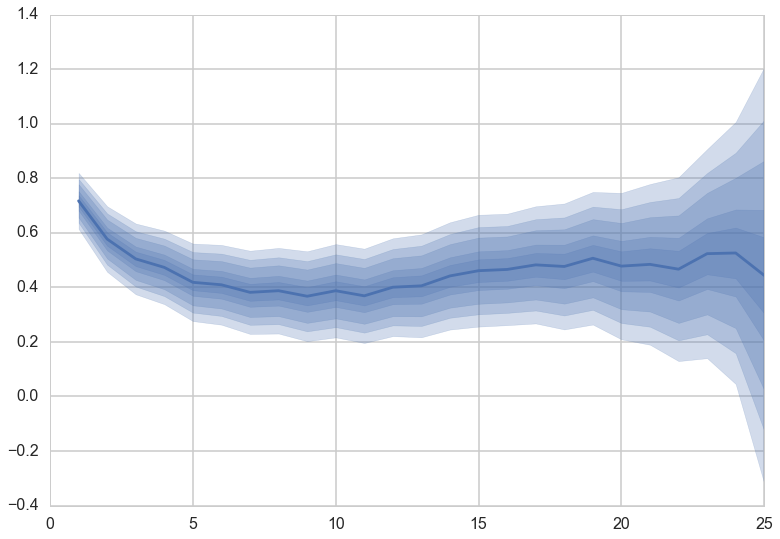

Portugal


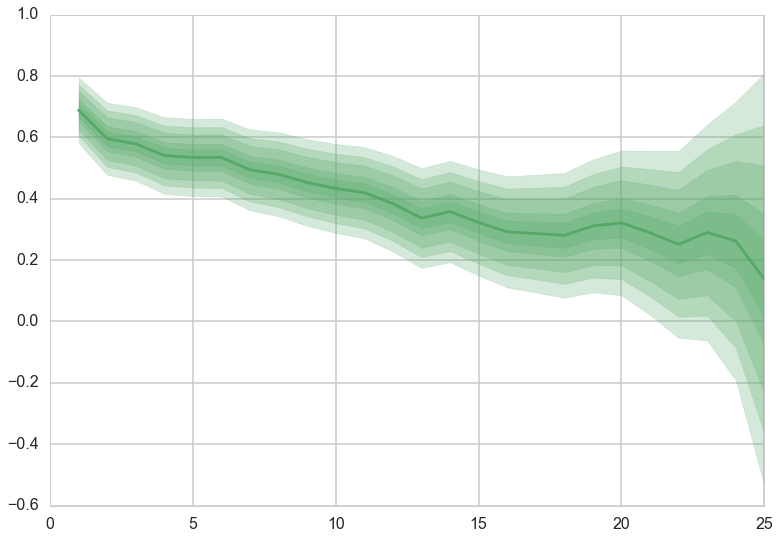

France


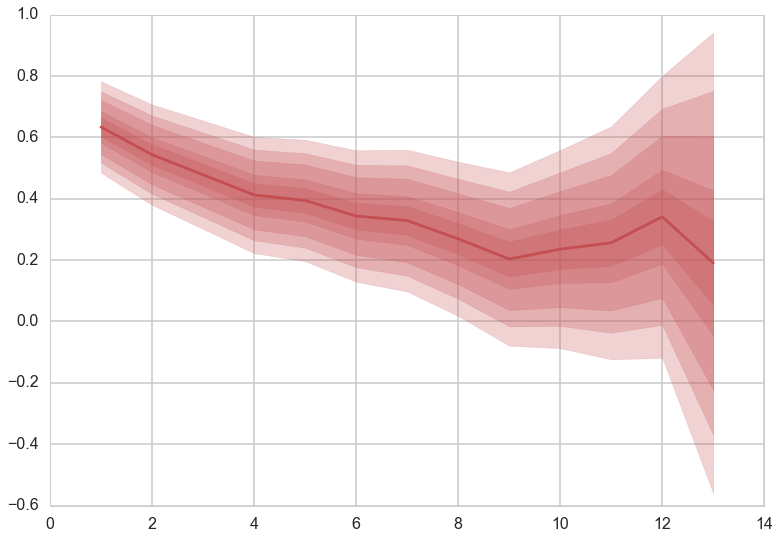

Germany


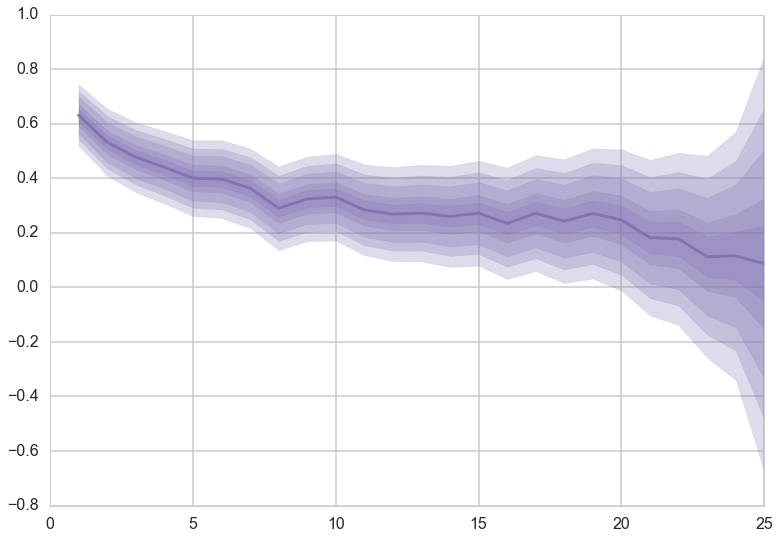

England


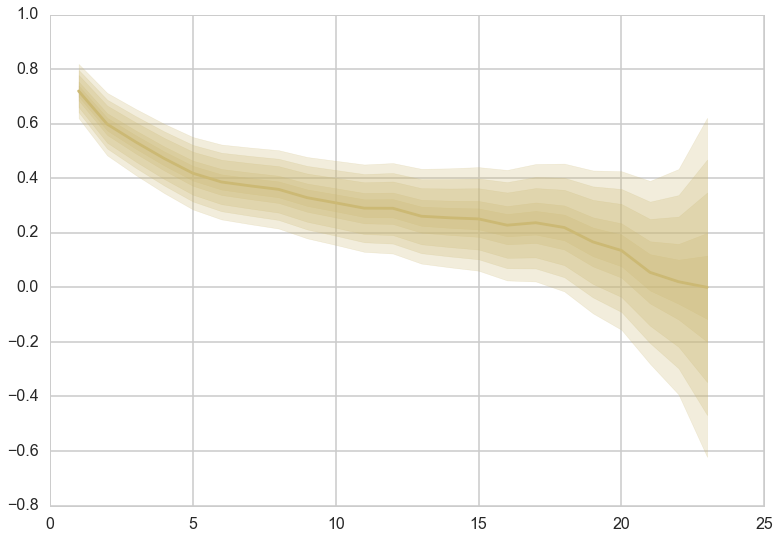

Spain


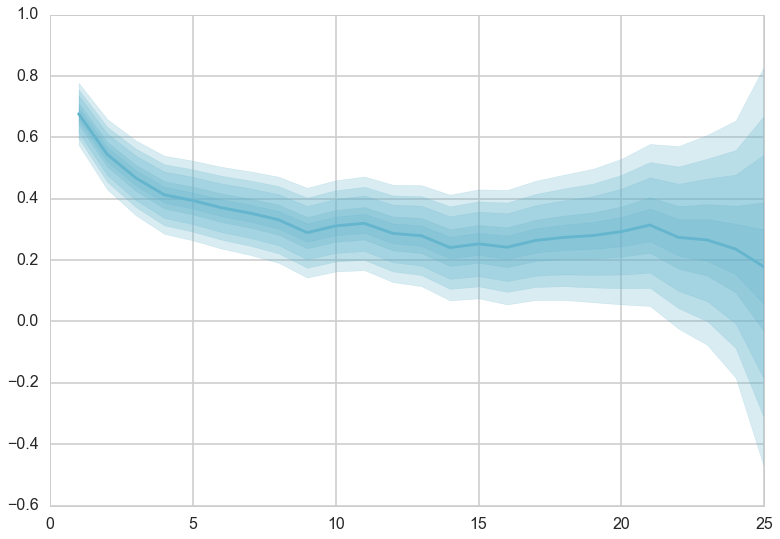

In [181]:
colors=sns.color_palette()
for c, (k, v) in zip(colors, pval_dict_.iteritems()):
    m, ints = zip(*pval_dict_[k].values())
    for i in zip(*ints):
        l, u = zip(*i)
        plt.fill_between(x = pval_dict_[k].keys(), y1 = l, y2 = u, color = c, alpha = .25)
    plt.plot(pval_dict_[k].keys(), m, color = c)
    
    print k
    plt.show()

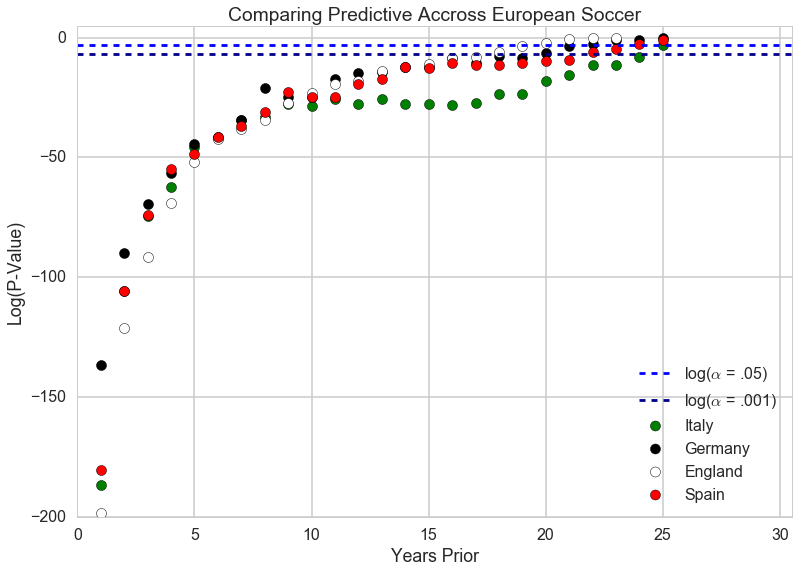

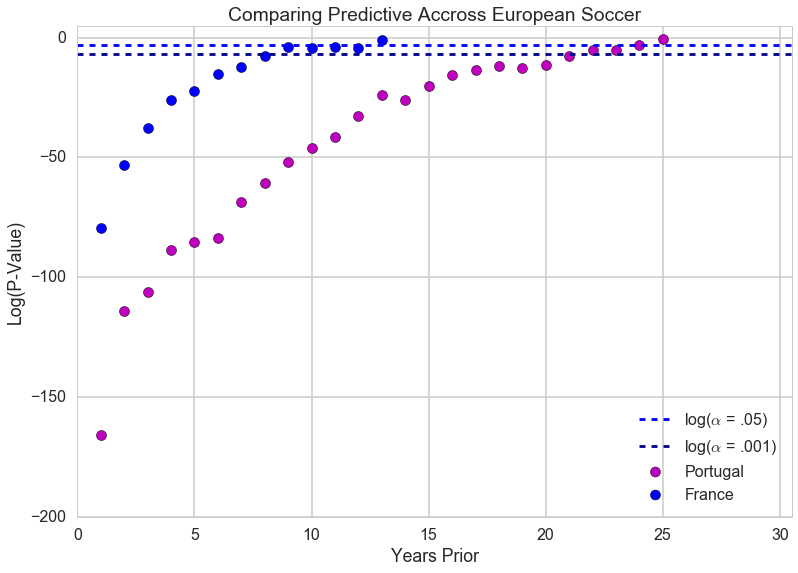

In [139]:
def plot2(d, leagues):
    plt.axhline(y = np.log(.05), c = 'b', linestyle = 'dashed', label = 'log($ \\alpha $ = .05)')
    plt.axhline(y = np.log(.001), c = 'darkblue', linestyle = 'dashed', label = 'log($ \\alpha $ = .001)')
    for (k, v), c in zip(d.iteritems(), "gmbkwr"):
        if k in leagues:
#            plt.axhline(y = np.log(.05), c = 'g', linestyle = 'dashed', label = '$ \\alpha $')
#            plt.axhline(y = np.log(.001), c = 'darkgreen', linestyle = 'dashed', label = '$ \\alpha $')
            plt.scatter(y = np.log(zip(*v.values())[1]), x = v.keys(), s = 100, c = c, label = k)
            plt.ylim([-200,5])
            plt.xlim([0, 30.5])
            plt.xlabel('Years Prior')
            plt.title("Comparing Predictive Accross European Soccer")
            plt.ylabel('Log(P-Value)')
            plt.legend(loc = 4)
    plt.show();

plot2(pval_dict, ["Spain", "England", "Germany", "Italy"])
plot2(pval_dict, ["France", "Portugal"])